In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [3]:
STFT = np.load('STFT.npy')
labels = np.load('LOS.npy')
STFT_signal= np.stack((abs(STFT), np.angle(STFT)), axis = 3)
STFT_signal.shape

(7102, 256, 9, 2)

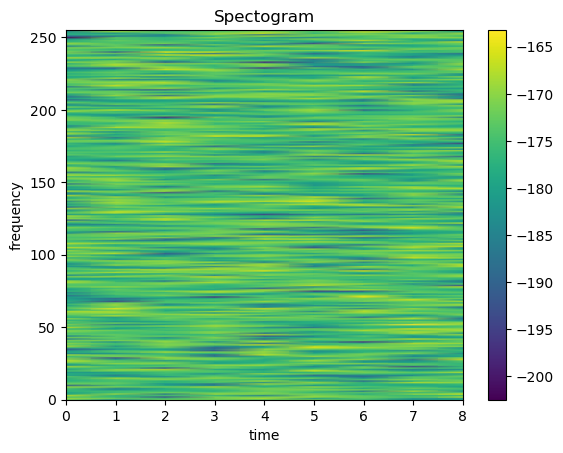

In [4]:
plt.pcolormesh(10 * np.log10(sp.fft.fftshift(STFT[3241,:,:], axes = 0)), shading='gouraud')
plt.colorbar()  # Add a colorbar for reference

# Set axis labels and title
plt.xlabel('time')
plt.ylabel('frequency')
plt.title('Spectogram')

# Show the plot
plt.show()


In [5]:
#PRS = np.load('PRS.npy')
#FE = np.load('FE.npy')
labels = np.load('LOS.npy')
#cor = np.load('cor.npy')
RX = np.load('RX_time.npy')
RX = np.transpose(np.reshape(np.stack((np.abs(RX), np.angle(RX)), axis = -2), (RX.shape[0], RX.shape[2], -1)), [0,2,1])
print(f'RX shape = {RX.shape}')#\ncorrelation shape = {cor.shape}\nstatistical feature shape = {FE.shape},\nLOS = {np.unique(labels, return_counts=True)}')
#print(f'statistical feature shape = {FE.shape},\nLOS/NLOS labels = {np.unique(labels, return_counts=True)}')

RX shape = (7102, 10, 2048)


In [6]:
import tensorflow as tf
from keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
tf.config.set_visible_devices([], 'GPU')

2023-11-07 15:18:08.455515: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.13.1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(RX, labels, test_size=0.2, random_state=42, stratify=labels)

In [ ]:
encoder = OneHotEncoder(sparse_output = False)
binary_labels = y_train.reshape(-1, 1)
y_onehot_encoded = encoder.fit_transform(binary_labels)

In [ ]:
# Create a Sequential model
model = tf.keras.Sequential(name = 'LSTM-Conv1D')

# Input layer for (2048, 5, 2)
model.add(layers.InputLayer(input_shape=(10,2048)))

# Add convolutional and pooling layers, and more as needed
model.add(layers.LSTM(64, return_sequences=True, kernel_regularizer=regularizers.L2(1e-5))) # You can adjust the number of units as needed
model.add(layers.Conv1D(32, kernel_size=3, strides=2, activation='relu', kernel_regularizer=regularizers.L2(1e-3)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(1e-3)))
model.add(layers.Dense(2, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy',
                                                                     tf.keras.metrics.F1Score(average = 'weighted', threshold = None, name = 'f1'), 
                                                                     tf.keras.metrics.AUC(num_thresholds=100, name = 'auc', from_logits=True),
                                                                         ])

# Print the model summary
model.summary()


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
validation_split = 0.2
history = model.fit(X_train, y_onehot_encoded, 
          #class_weight=class_weight_dict, 
          #validation_data=(X_val, y_val), 
          validation_split=validation_split,
          callbacks=[early_stopping],
          epochs=50, batch_size=128, shuffle=True)

In [ ]:
print(history.history.keys())


# Create a figure with two subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))

# Plot training & validation loss values on the first subplot (ax1)
ax1.plot(history.history['loss'], label='Training')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Training')
ax2.plot(history.history['val_accuracy'], label='Validation')
ax2.set_title('Model accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('accuracy')
ax2.legend()

ax3.plot(history.history['auc'], label='Training')
ax3.plot(history.history['val_auc'], label='Validation')
ax3.set_title('Model AUC')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('auc')
ax3.legend()

ax4.plot(history.history['f1'], label='Training')
ax4.plot(history.history['val_f1'], label='Validation')
ax4.set_title('Model f1')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('f1')
ax4.legend()
plt.show()



In [ ]:
class_names = ['LOS', 'NLOS']
y_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1], drop_intermediate = True)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]
#plt.plot(fpr,tpr)
y_pred = (y_proba[:, 1] > optimal_threshold).astype(int)  # Assuming binary classification
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(cm, annot=True,  cbar = False, cmap="Blues", fmt=".2%", xticklabels=class_names, yticklabels=class_names)


In [ ]:
!nvidia-smi